In [59]:
import pandas as pd
import numpy as np

from statsmodels.formula.api import ols
import statsmodels.stats.diagnostic as cu
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts 

import seaborn as sns
from statsmodels.tsa.stattools import adfuller, coint




In [2]:
real_gdp_log = pd.read_csv("preprocessed_data/real_gdp_log.csv", index_col="Year")
total_work_hours_log = pd.read_csv("preprocessed_data/total_work_hours_log.csv", index_col="Year")
capital_stock_log = pd.read_csv("preprocessed_data/capital_stock_log.csv", index_col="Year")

#employment = pd.read_csv("employment.csv", index_col="Year")


In [76]:
def print_adfuller (x):
    #result = adfuller(x)
    result = adfuller(x, maxlag=1, autolag=None, regression='ct')   #각 데이터 모두 trend가 존재한다고 판단하여 옵션을 "ct"로 줌
    print(f'ADF Statistic: {result[0]:.3f}')
    print(f'p-value: {result[1]:.3f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))


def print_coint (y, x):
    #result = adfuller(x)
    result = coint(y, x, trend='ct')   #각 데이터 모두 trend가 존재한다고 판단하여 옵션을 "ct"로 줌
    print(f'coint T-Statistic: {result[0]:.3f}')
    print(f'p-value: {result[1]:.3f}')
    print('Critical Values:')
    for value in result[2]:
        print('\t: %.3f' % (value))

In [19]:
korea = pd.concat([real_gdp_log['Korea'], capital_stock_log['Korea'], total_work_hours_log['Korea']], axis=1)
korea.columns = ['lnY', 'lnK', 'lnL']
korea.dropna(axis=0, inplace=True)
korea['trend'] = range(1, len(korea)+1)
korea['intercept'] = np.ones(len(korea))
korea['first_dummy'] = np.zeros(len(korea))
korea.at[range(1997,2002), 'first_dummy'] =1
korea

,lnY,lnK,lnL,trend,intercept,first_dummy
Year,,,,,,
1983,26.417000,13.838709,17.468007,1,1.0,0.0
1984,26.479084,13.932134,17.457334,2,1.0,0.0
1985,26.478093,14.020440,17.494166,3,1.0,0.0
1986,26.572349,14.114044,17.507238,4,1.0,0.0
1987,26.761249,14.217278,17.589812,5,1.0,0.0
1988,26.991848,14.323022,17.626227,6,1.0,0.0
1989,27.145788,14.433782,17.642814,7,1.0,0.0
1990,27.187336,14.561260,17.659299,8,1.0,0.0
1991,27.254176,14.688802,17.682546,9,1.0,0.0


ADF stationary test


-> 한국의 lnY, lnL, lnK 데이터는 모두 non-stationary하다

In [54]:
print_adfuller(korea['lnY'])
print()
print_adfuller(korea['lnL'])
print()
print_adfuller(korea['lnK'])


ADF Statistic: -2.974
p-value: 0.140
Critical Values:
	1%: -4.244
	5%: -3.544
	10%: -3.205

ADF Statistic: -2.683
p-value: 0.243
Critical Values:
	1%: -4.244
	5%: -3.544
	10%: -3.205

ADF Statistic: -2.267
p-value: 0.452
Critical Values:
	1%: -4.244
	5%: -3.544
	10%: -3.205


In [77]:
coint(korea['lnY'], korea[['lnK', 'lnL']], trend='ct')
print_coint(korea['lnY'], korea[['lnK', 'lnL']])

coint T-Statistic: -4.349
p-value: 0.026
Critical Values:
	: -5.221
	: -4.462
	: -4.093


In [15]:
model = ols("lnY ~ lnK + lnL + trend", data = korea).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lnY   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     248.2
Date:                Wed, 01 Jun 2022   Prob (F-statistic):           1.05e-22
Time:                        05:40:51   Log-Likelihood:                 32.452
No. Observations:                  37   AIC:                            -56.90
Df Residuals:                      33   BIC:                            -50.46
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -32.6602      8.330     -3.921      0.000     -49.608     -15.712
lnK           -0.5699      0.185     -3.078      0.004      -0.947      -0.193
lnL            3.8322      0.591      6.479      0.000       2.629       5.035
trend          0.0503      0.009      5.694      0.000       0.032       0.068
==============================================================================
Omnibus:                        0.907   Durbin-Watson:                   0.903
Prob(Omnibus):                  0.635   Jarque-Bera (JB):                0.932
Skew:                          -0.330   Prob(JB):                        0.628
Kurtosis:                       2.588   Cond. No.                     1.48e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.48e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

c:\Users\JongHwi\anaconda3\envs\pytorch\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


c:\Users\JongHwi\anaconda3\envs\pytorch\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


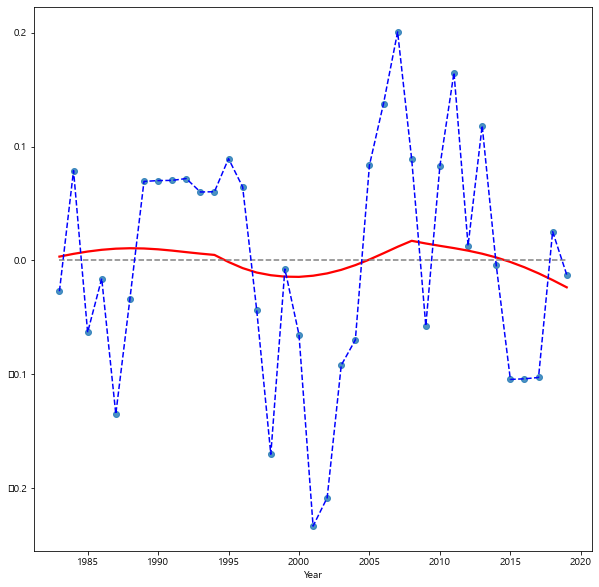

In [65]:
Y_predict = model.predict(korea)
residual = korea['lnY'] - Y_predict

plt.rc("font", family='Malgun Gothic')
plt.rcParams["figure.figsize"] = (10, 10)
sns.regplot(residual.index, residual, lowess=True, line_kws={'color': 'red'})
plt.plot([residual.index.min(), residual.index.max()], [0, 0], '--', color='grey')
plt.plot(residual.index, residual, '--', color='blue')


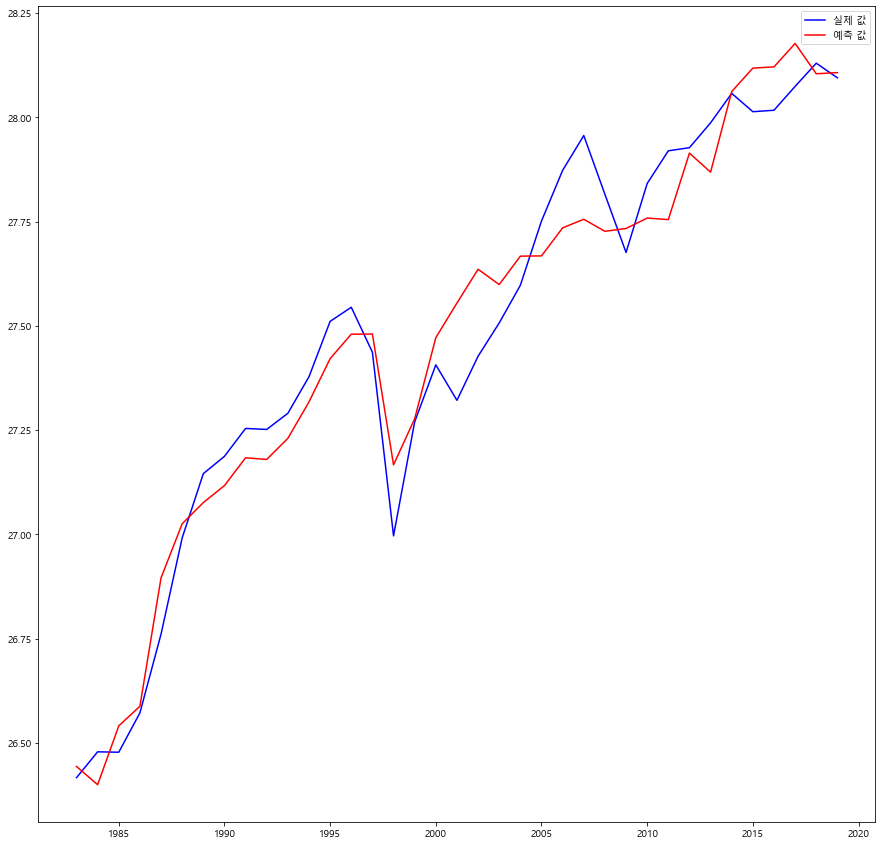

In [66]:
plt.rc("font", family='Malgun Gothic')
plt.rcParams["figure.figsize"] = (15, 15)
plt.plot(korea.index, korea['lnY'], color='blue', label='실제 값')
plt.plot(Y_predict.index, Y_predict, color='red', label='예측 값')
plt.legend()


In [47]:
usa = pd.concat([real_gdp_log['USA'], capital_stock_log['USA'], total_work_hours_log['USA']], axis=1).dropna()
usa.columns = ['lnY', 'lnK', 'lnL']
usa['trend'] = range(1, len(usa)+1)
usa['intercept'] = np.ones(len(usa))
usa['first_dummy'] = np.zeros(len(usa))
usa.at[range(1982,1985), 'first_dummy'] =1
usa

,lnY,lnK,lnL,trend,intercept,first_dummy
Year,,,,,,
1960,28.871477,16.504169,18.670620,1,1.0,0.0
1961,28.894216,16.537153,18.664504,2,1.0,0.0
1962,28.953428,16.572959,18.688697,3,1.0,0.0
1963,28.996488,16.610436,18.710573,4,1.0,0.0
1964,29.052868,16.650116,18.734587,5,1.0,0.0
1965,29.114903,16.692038,18.764545,6,1.0,0.0
1966,29.177878,16.734955,18.784636,7,1.0,0.0
1967,29.202571,16.773725,18.792927,8,1.0,0.0
1968,29.249454,16.812002,18.807879,9,1.0,0.0


In [55]:
print_adfuller(usa['lnY'])
print()
print_adfuller(usa['lnK'])
print()
print_adfuller(usa['lnL'])


ADF Statistic: -2.429
p-value: 0.364
Critical Values:
	1%: -4.124
	5%: -3.489
	10%: -3.173

ADF Statistic: -1.319
p-value: 0.883
Critical Values:
	1%: -4.124
	5%: -3.489
	10%: -3.173

ADF Statistic: -1.872
p-value: 0.669
Critical Values:
	1%: -4.124
	5%: -3.489
	10%: -3.173


In [89]:
coint(usa['lnY'], usa[['lnK', 'lnL']], trend='c')
#print_coint(usa['lnY'], usa[['lnK', 'lnL']])

(-2.30857756903013,
 0.5854397561399064,
 array([-4.5477129 , -3.88878023, -3.5585752 ]))

In [17]:
model = ols("lnY ~ lnK + lnL + trend", data = usa).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lnY   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 1.082e+04
Date:                Wed, 01 Jun 2022   Prob (F-statistic):           2.49e-77
Time:                        05:41:19   Log-Likelihood:                 145.88
No. Observations:                  60   AIC:                            -283.8
Df Residuals:                      56   BIC:                            -275.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.2434      1.072     10.486      0.000       9.095      13.391
lnK            0.5868      0.095      6.197      0.000       0.397       0.776
lnL            0.4266      0.098      4.341      0.000       0.230       0.623
trend          0.0082      0.002      5.025      0.000       0.005       0.011
==============================================================================
Omnibus:                        0.096   Durbin-Watson:                   0.319
Prob(Omnibus):                  0.953   Jarque-Bera (JB):                0.294
Skew:                           0.015   Prob(JB):                        0.863
Kurtosis:                       2.659   Cond. No.                     1.60e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.6e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

c:\Users\JongHwi\anaconda3\envs\pytorch\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


c:\Users\JongHwi\anaconda3\envs\pytorch\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


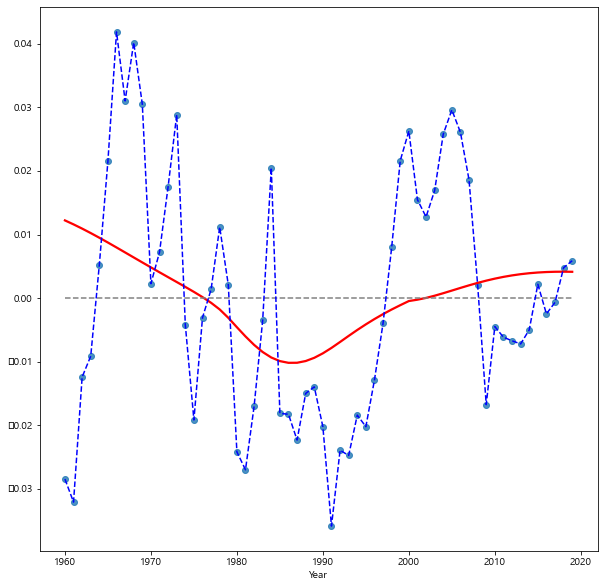

In [5]:
Y_predict = model.predict(usa)
residual = usa['lnY'] - Y_predict

plt.rc("font", family='Malgun Gothic')
plt.rcParams["figure.figsize"] = (10, 10)
sns.regplot(residual.index, residual, lowess=True, line_kws={'color': 'red'})
plt.plot([residual.index.min(), residual.index.max()], [0, 0], '--', color='grey')
plt.plot(residual.index, residual, '--', color='blue')


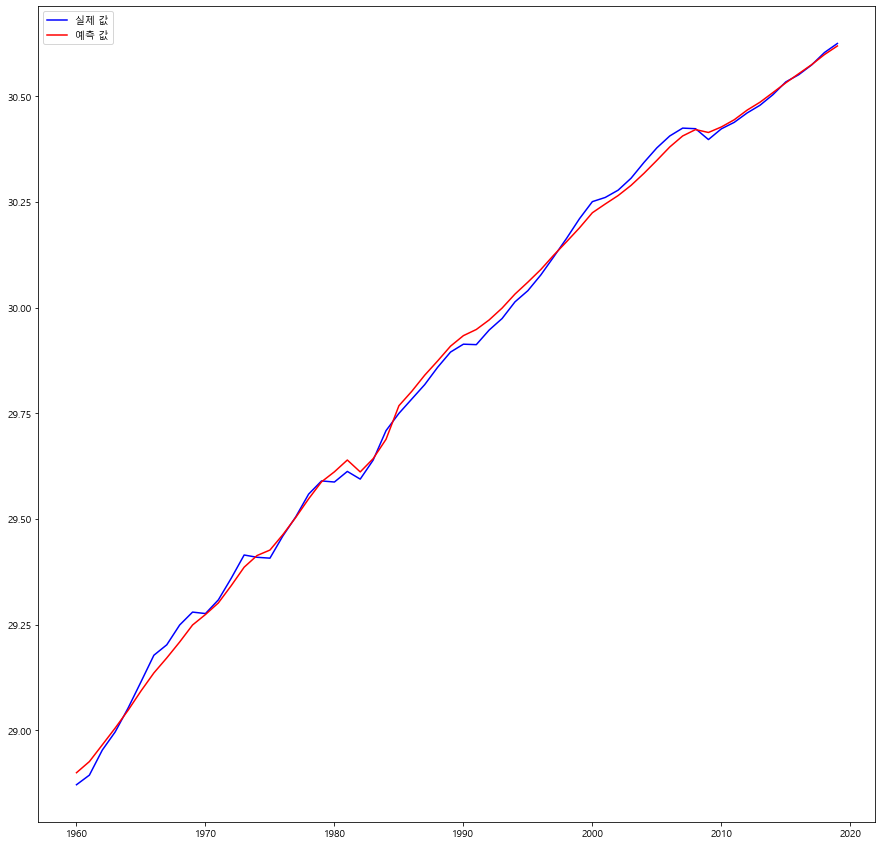

In [6]:
plt.rc("font", family='Malgun Gothic')
plt.rcParams["figure.figsize"] = (15, 15)
plt.plot(usa.index, usa['lnY'], color='blue', label='실제 값')
plt.plot(Y_predict.index, Y_predict, color='red', label='예측 값')
plt.legend()


c:\Users\JongHwi\anaconda3\envs\pytorch\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


c:\Users\JongHwi\anaconda3\envs\pytorch\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


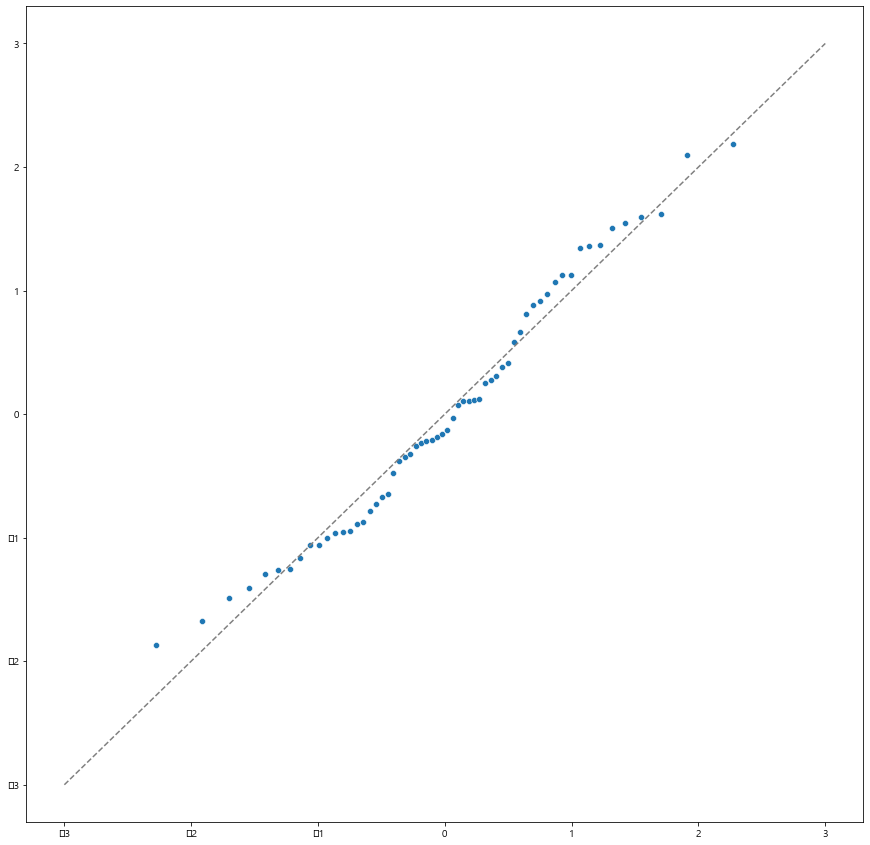

In [7]:
import scipy.stats

sr = scipy.stats.zscore(residual)
(x, y), _ = scipy.stats.probplot(sr)
sns.scatterplot(x, y)
plt.plot([-3, 3], [-3, 3], '--', color='grey')

In [69]:
len(usa)

60

In [70]:
Y = usa['lnY'].to_numpy()
Y_avg = np.average(Y)
X = usa[['intercept', 'trend', 'lnK', 'lnL']].to_numpy()

N = len(usa)
K = 4

XX = X.transpose().dot(X)
XX_inv = np.linalg.inv(XX)
XY = X.transpose().dot(Y)

beta = XX_inv.dot(XY)

In [71]:
for b in beta:
    print(np.around(b,3))

11.243
0.008
0.587
0.427


In [72]:
Y_hat = X.dot(beta)
Y_hat_avg = np.average(Y_hat)
resid = Y - Y_hat

SSR = resid**2
SSE = (Y_hat - Y_hat_avg)**2
SST = (Y - Y_avg)**2
SST

e_std_dev = SSR.sum()/(N-K)
R_square = SSE.sum()/SST.sum()
adj_R_square = 1 - ( (SSR.sum()/(N-K)) / (SST.sum()/N) )



beta_var = e_std_dev * XX_inv
beta_var_diag =np.diag(beta_var)
beta_var_inv = np.linalg.inv(beta_var)
beta_var_inv_dig = np.diag(beta_var_inv)

std_dev_beta = np.sqrt(beta_var_diag)
t_value = beta/std_dev_beta





In [74]:
adj_R_square

0.9981540590368655

In [24]:
R = np.array([[0, 0, 1, 1], [1,0,0,0]])
r = np.array([1, 0])

#np.linalg.inv(np.matmul(R, np.matmul(XX_inv, R.transpose())))

RVR_inv = np.linalg.inv(np.matmul(np.matmul(R, beta_var), R.transpose()))
RVR_inv

Rb = (np.matmul(R, beta)-r).transpose()

np.matmul(RVR_inv, Rb)

chai_sq = np.matmul(Rb.transpose(), np.matmul(RVR_inv, Rb))
chai_sq

#F = chai_sq / 2


#pd.DataFrame(chai_sq)


3487.9306245656176

NameError: name 'Y_hat' is not defined

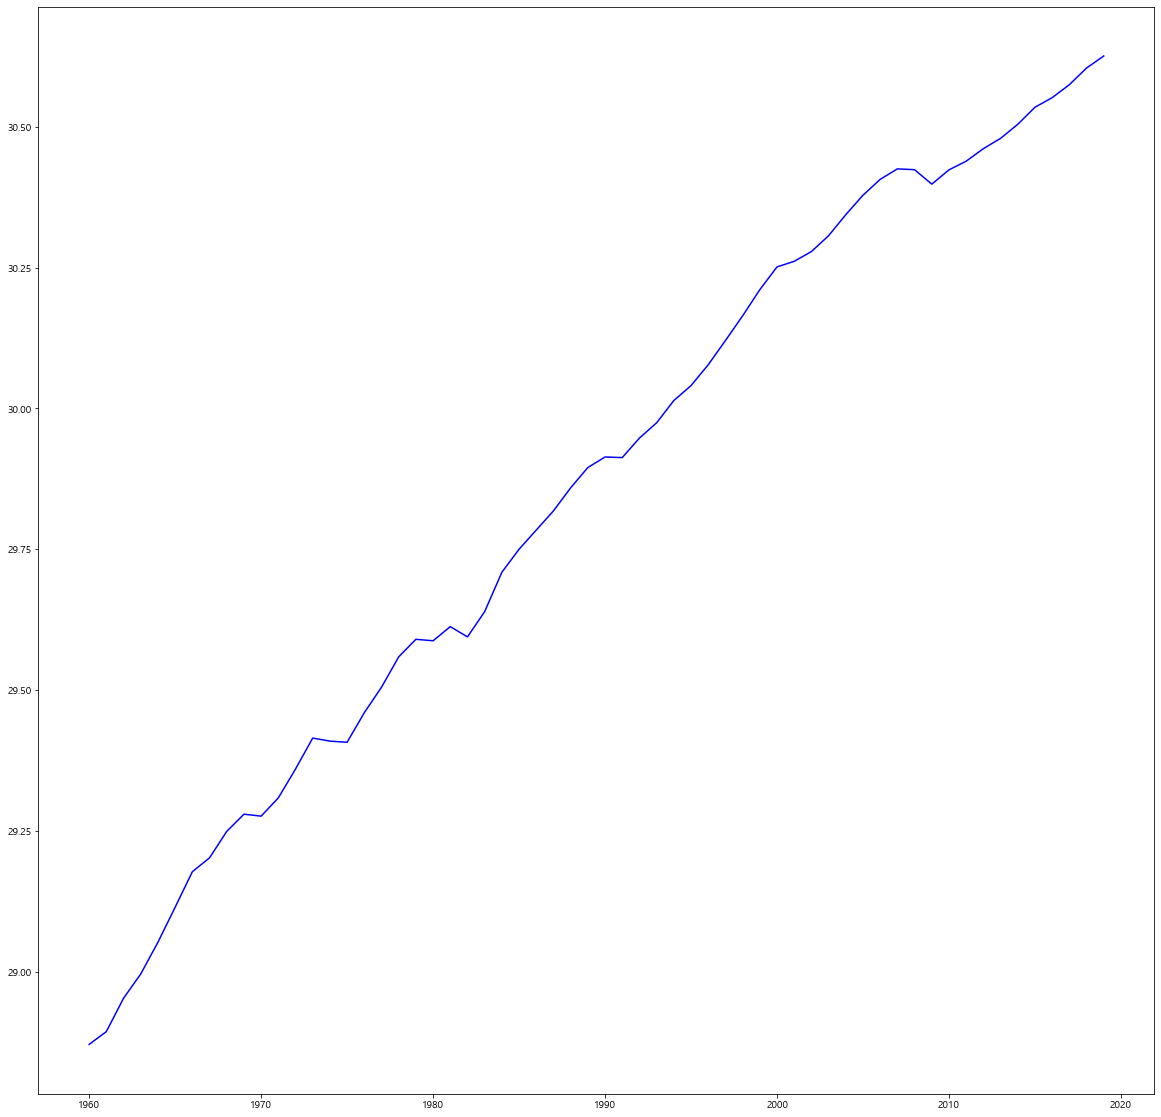

In [89]:
plt.rcParams["figure.figsize"] = (20, 20)
plt.plot(usa.index, Y, color='blue')
plt.plot(usa.index, Y_hat, color='red')
plt.xticks(range(1960, 2024, 2), rotation=45)
plt.show()

In [56]:
japan = pd.concat([real_gdp_log['Japan'], capital_stock_log['Japan'], total_work_hours_log['Japan']], axis=1).dropna()
japan.columns = ['lnY', 'lnK', 'lnL']
japan['trend'] = (range(1, len(japan)+1))
japan['intercept'] = np.ones(len(japan))
japan


,lnY,lnK,lnL,trend,intercept
Year,,,,,
1970,26.919705,15.477723,18.553957,1,1.0
1971,26.991862,15.595414,18.557637,2,1.0
1972,27.218209,15.708076,18.557096,3,1.0
1973,27.405071,15.819373,18.566948,4,1.0
1974,27.320410,15.902431,18.533216,5,1.0
1975,27.334878,15.974494,18.518739,6,1.0
1976,27.374650,16.041853,18.535403,7,1.0
1977,27.516953,16.105077,18.549286,8,1.0
1978,27.812007,16.169214,18.558759,9,1.0


일본 lnY, lnK, lnL 데이터에 대해 stationary한지 ADF를 통해 검정

모두 stationary하지 못하다

In [57]:
print_adfuller(japan['lnY'])
print()
print_adfuller(japan['lnK'])
print()
print_adfuller(japan['lnL'])


ADF Statistic: -1.613
p-value: 0.787
Critical Values:
	1%: -4.161
	5%: -3.506
	10%: -3.183

ADF Statistic: -1.350
p-value: 0.875
Critical Values:
	1%: -4.161
	5%: -3.506
	10%: -3.183

ADF Statistic: -1.546
p-value: 0.813
Critical Values:
	1%: -4.161
	5%: -3.506
	10%: -3.183


In [86]:
coint(japan['lnY'], japan[['lnK', 'lnL']])
#print_coint(japan['lnY'], japan[['lnK', 'lnL']])

(-3.7540596138176827,
 0.048333671991684354,
 array([-4.60176232, -3.91970112, -3.58055097]))

In [38]:
model = ols("lnY ~ lnK + lnL + trend", data = japan).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lnY   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     402.0
Date:                Tue, 31 May 2022   Prob (F-statistic):           5.39e-33
Time:                        23:02:27   Log-Likelihood:                 25.488
No. Observations:                  50   AIC:                            -42.98
Df Residuals:                      46   BIC:                            -35.33
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -18.3216     12.136     -1.510      0.138     -42.750       6.107
lnK            1.1506      0.176      6.552      0.000       0.797       1.504
lnL            1.4698      0.758      1.940      0.058      -0.055       2.995
trend          0.0167      0.006      2.765      0.008       0.005       0.029
==============================================================================
Omnibus:                        0.157   Durbin-Watson:                   0.493
Prob(Omnibus):                  0.925   Jarque-Bera (JB):                0.290
Skew:                          -0.118   Prob(JB):                        0.865
Kurtosis:                       2.711   Cond. No.                     2.12e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.12e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

c:\Users\JongHwi\anaconda3\envs\pytorch\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


c:\Users\JongHwi\anaconda3\envs\pytorch\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


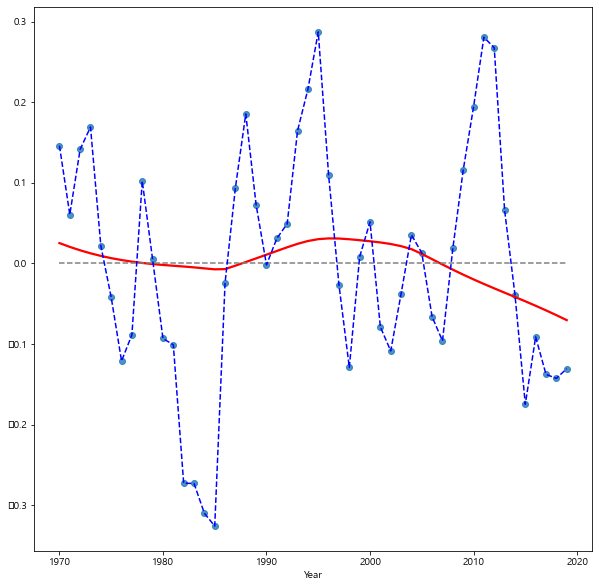

In [39]:
Y_predict = model.predict(japan)
residual = japan['lnY'] - Y_predict

plt.rc("font", family='Malgun Gothic')
plt.rcParams["figure.figsize"] = (10, 10)
sns.regplot(residual.index, residual, lowess=True, line_kws={'color': 'red'})
plt.plot([residual.index.min(), residual.index.max()], [0, 0], '--', color='grey')
plt.plot(residual.index, residual, '--', color='blue')


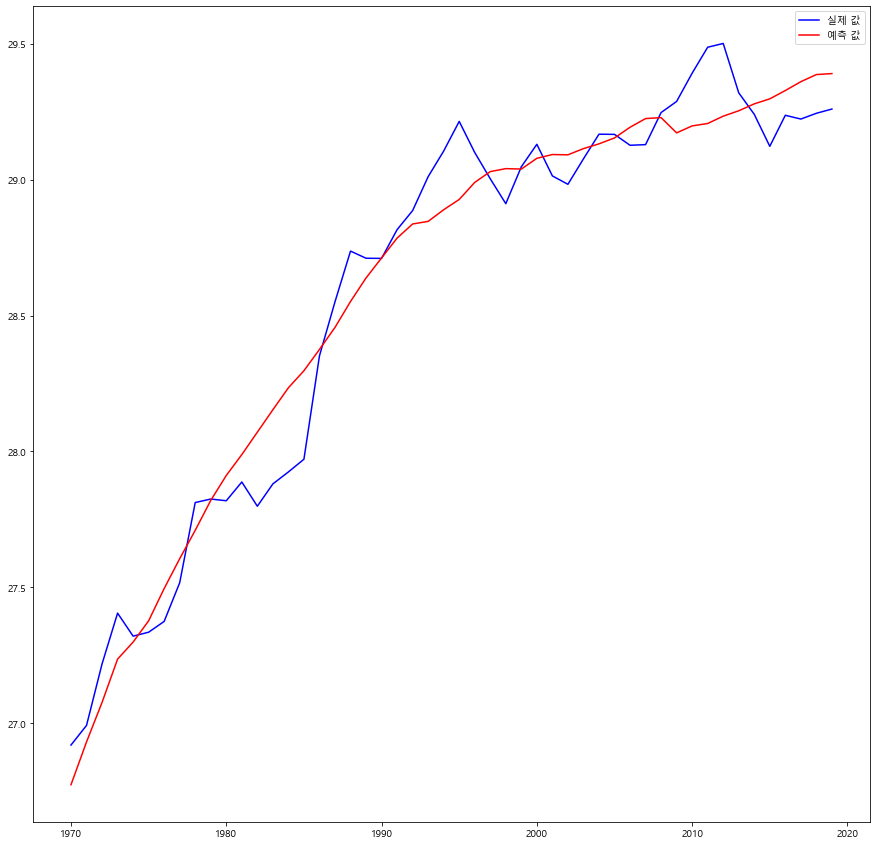

In [40]:
plt.rc("font", family='Malgun Gothic')
plt.rcParams["figure.figsize"] = (15, 15)
plt.plot(japan.index, japan['lnY'], color='blue', label='실제 값')
plt.plot(Y_predict.index, Y_predict, color='red', label='예측 값')
plt.legend()


In [ ]:
korea = pd.concat([real_gdp_log['Japan'], capital_stock_log['Japan'], total_work_hours_log['Japan']], axis=1).dropna()
japan.columns = ['lnY', 'lnK', 'lnL']
japan['trend'] = np.log(range(1, len(japan)+1))
japan['intercept'] = np.ones(len(japan))
japan


In [206]:
len(japan)

50

In [278]:
Y = usa['lnY'].to_numpy()
Y_avg = np.average(Y)
X = usa[['intercept', 'trend', 'lnK', 'lnL', 'first_dummy']].to_numpy()

N = 50
K = 5

XX = X.transpose().dot(X)
XX_inv = np.linalg.inv(XX)
XY = X.transpose().dot(Y)

beta = XX_inv.dot(XY)



In [279]:
Y_hat = X.dot(beta)
Y_hat_avg = np.average(Y_hat)
resid = Y - Y_hat

SSR = resid**2
SSE = (Y_hat - Y_hat_avg)**2
SST = (Y - Y_avg)**2
SST

e_std_dev = SSR.sum()/(N-K)
R_square = SSE.sum()/SST.sum()
adj_R_square = 1 - ( (SSR.sum()/(N-K)) / (SST.sum()/N) )


In [280]:
beta_var = e_std_dev * XX_inv
beta_var_diag =np.diag(beta_var)
beta_var_inv = np.linalg.inv(beta_var)
beta_var_inv_dig = np.diag(beta_var_inv)

std_dev_beta = np.sqrt(beta_var_diag)
t_value = beta/std_dev_beta

In [256]:
R = np.array([0, 0, 1, 1])
r = np.array([1])

In [229]:
np.linalg.inv(np.matmul(R, np.matmul(XX_inv, R.transpose())))

RVR_inv = np.linalg.inv(np.matmul(np.matmul(R, beta_var), R.transpose()))
RVR_inv

Rb = (np.matmul(R, beta)-r).transpose()

np.matmul(RVR_inv, Rb)

chai_sq = np.matmul(Rb.transpose(), np.matmul(RVR_inv, Rb))
chai_sq

#F = chai_sq / 2

array([[2865.08587018]])

In [212]:
pd.DataFrame(chai_sq)

,0
0,3.090227


In [273]:
cu.breaks_cusumolsresid(resid, ddof=4)

(1.1249663131045695, 0.15906296097793685, [(1, 1.63), (5, 1.36), (10, 1.22)])

In [5]:
plt.rcParams["figure.figsize"] = (20, 20)
plt.plot(usa.index, Y, color='blue')
plt.plot(usa.index, Y_hat, color='red')
plt.xticks(range(1960, 2024, 2), rotation=45)
plt.show()

NameError: name 'usa' is not defined

c:\Users\kimjo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\kimjo\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\kimjo\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


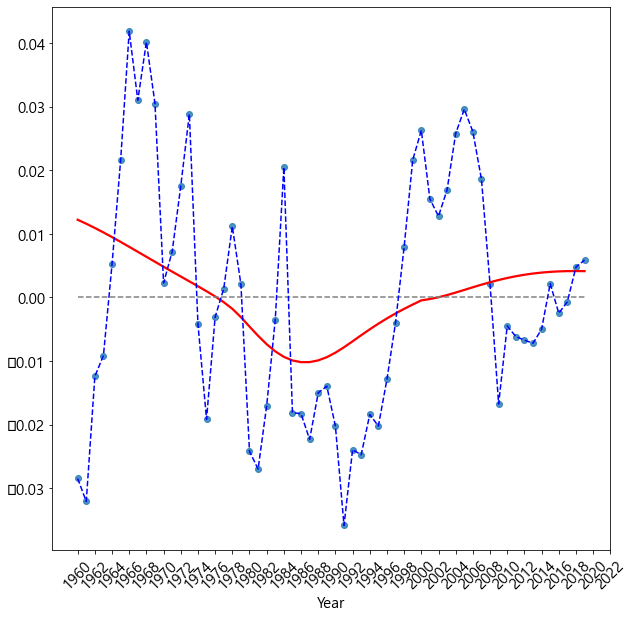

In [282]:
plt.rcParams["figure.figsize"] = (10, 10)
sns.regplot(usa.index, resid, lowess=True, line_kws={'color': 'red'})
plt.plot([usa.index.min(), usa.index.max()], [0, 0], '--', color='grey')
plt.plot(usa.index, resid, '--', color='blue')
plt.xticks(range(1960, 2024, 2), rotation=45)
plt.show()

In [24]:
employment = np.log(employment)
employment

,Korea,Japan,USA
Year,,,
1955,NaN,2.362624,2.401311
1956,NaN,2.364468,2.403653
1957,NaN,2.366894,2.404031
1958,NaN,2.367280,2.402563
1959,NaN,2.368112,2.404820
...,...,...,...
2016,2.320569,2.404920,2.478882
2017,2.321735,2.405922,2.479927
2018,2.322092,2.407824,2.481240


In [7]:
real_gdp_log

,"Korea, Rep.",Japan,United States
Year,,,
1960,26.855618,26.002524,28.871477
1961,26.241150,26.116241,28.894216
1962,26.238474,26.201583,28.953428
1963,26.324841,26.282920,28.996488
1964,25.917631,26.393358,29.052868
...,...,...,...
2016,28.016894,29.237004,30.551516
2017,28.074202,29.223084,30.574574
2018,28.129693,29.244317,30.604100


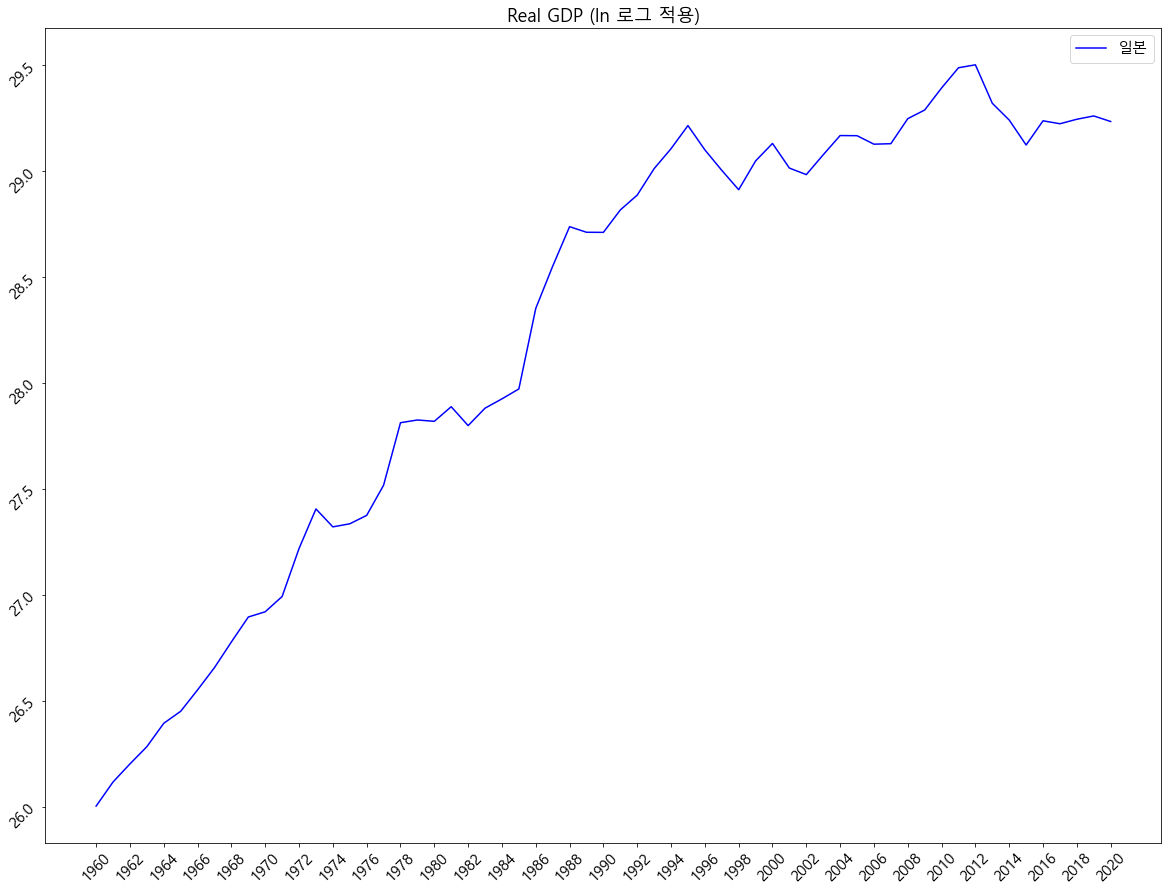

In [8]:
plt.rc("font", family='Malgun Gothic')
plt.rc('font', size=15) 
plt.figure(figsize=(20,15))
#plt.plot(real_gdp_log.index, real_gdp_log['Korea, Rep.'], label='한국', color='red')
plt.plot(real_gdp_log.index, real_gdp_log['Japan'], label='일본', color='blue')
#plt.plot(real_gdp_log.index, real_gdp_log['United States'], label='미국', color='green')
plt.title('Real GDP (ln 로그 적용)')
plt.legend()
plt.xticks(np.arange(1960,2022,2),rotation=45)
plt.yticks(rotation=45)
plt.show()

In [22]:
total_work_hours_log

,Korea,Japan,USA
Year,,,
1955,NaN,NaN,18.640034
1956,NaN,NaN,18.665420
1957,NaN,NaN,18.655010
1958,NaN,NaN,18.625512
1959,NaN,NaN,18.656110
...,...,...,...
2016,17.815802,18.524127,19.411161
2017,17.803211,18.532311,19.423640
2018,17.794377,18.536307,19.441570


In [58]:
total_work_hours_log

,Korea,Japan,USA
Year,,,
1955,NaN,NaN,18.640034
1956,NaN,NaN,18.665420
1957,NaN,NaN,18.655010
1958,NaN,NaN,18.625512
1959,NaN,NaN,18.656110
...,...,...,...
2016,17.813865,18.524127,19.411161
2017,17.821087,18.532311,19.423640
2018,17.793875,18.536307,19.441570


In [43]:
korea = pd.concat([capital_stock_log['Korea'], real_gdp_log['Korea, Rep.'], total_work_hours_log['Korea']], axis=1)
korea.columns = ['Capital_stock', 'Real_gdp', 'Work_hours']
korea.dropna(axis=0, inplace=True)
korea['first_dummy'] = np.zeros(len(korea))
korea.at[range(1997,2002), 'first_dummy'] =1
korea

,Capital_stock,Real_gdp,Work_hours,first_dummy
Year,,,,
1983,13.838709,26.417000,17.468007,0.0
1984,13.932134,26.479084,17.457334,0.0
1985,14.020440,26.478093,17.494166,0.0
1986,14.114044,26.572349,17.507238,0.0
1987,14.217278,26.761249,17.589812,0.0
1988,14.323022,26.991848,17.626227,0.0
1989,14.433782,27.145788,17.642814,0.0
1990,14.561260,27.187336,17.659299,0.0
1991,14.688802,27.254176,17.682546,0.0


In [44]:
korea['Time'] = np.log(range(1, len(korea)+1))

In [45]:
model = ols("Real_gdp ~ Capital_stock + Work_hours + first_dummy + Time", data = korea).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Real_gdp   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     179.9
Date:                Tue, 31 May 2022   Prob (F-statistic):           1.90e-21
Time:                        20:21:04   Log-Likelihood:                 32.394
No. Observations:                  37   AIC:                            -54.79
Df Residuals:                      32   BIC:                            -46.73
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -9.0967     10.682     -0.852      0.401     -30.855      12.662
Capital_stock     0.3679      0.099      3.702      0.001       0.165       0.570
Work_hours        1.7402      0.607      2.866      0.007       0.503       2.977
first_dummy      -0.2928      0.052     -5.587      0.000      -0.400      -0.186
Time              0.0481      0.109      0.441      0.662      -0.174       0.271
==============================================================================
Omnibus:                       10.388   Durbin-Watson:                   1.105
Prob(Omnibus):                  0.006   Jarque-Bera (JB):                9.478
Skew:                          -1.126   Prob(JB):                      0.00875
Kurtosis:                       4.038   Cond. No.                     1.42e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.42e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

c:\Users\JongHwi\anaconda3\envs\pytorch\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


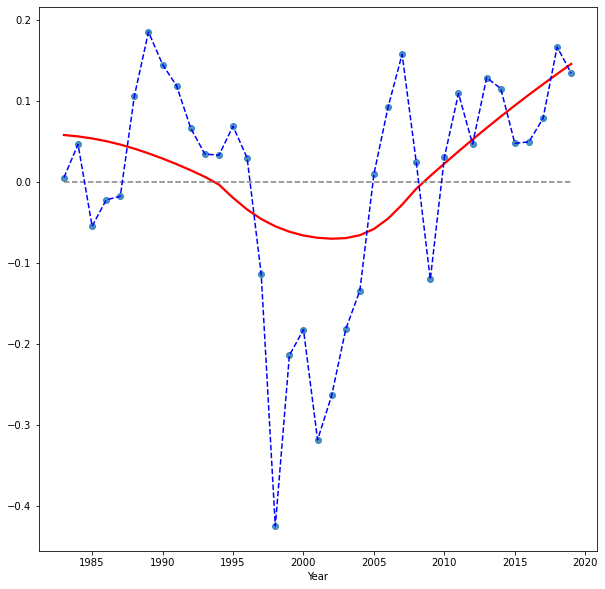

In [19]:
fitted = model.predict(korea)
residual = korea['Real_gdp'] - fitted

plt.rcParams["figure.figsize"] = (10, 10)
sns.regplot(residual.index, residual, lowess=True, line_kws={'color': 'red'})
plt.plot([residual.index.min(), residual.index.max()], [0, 0], '--', color='grey')
plt.plot(residual.index, residual, '--', color='blue')

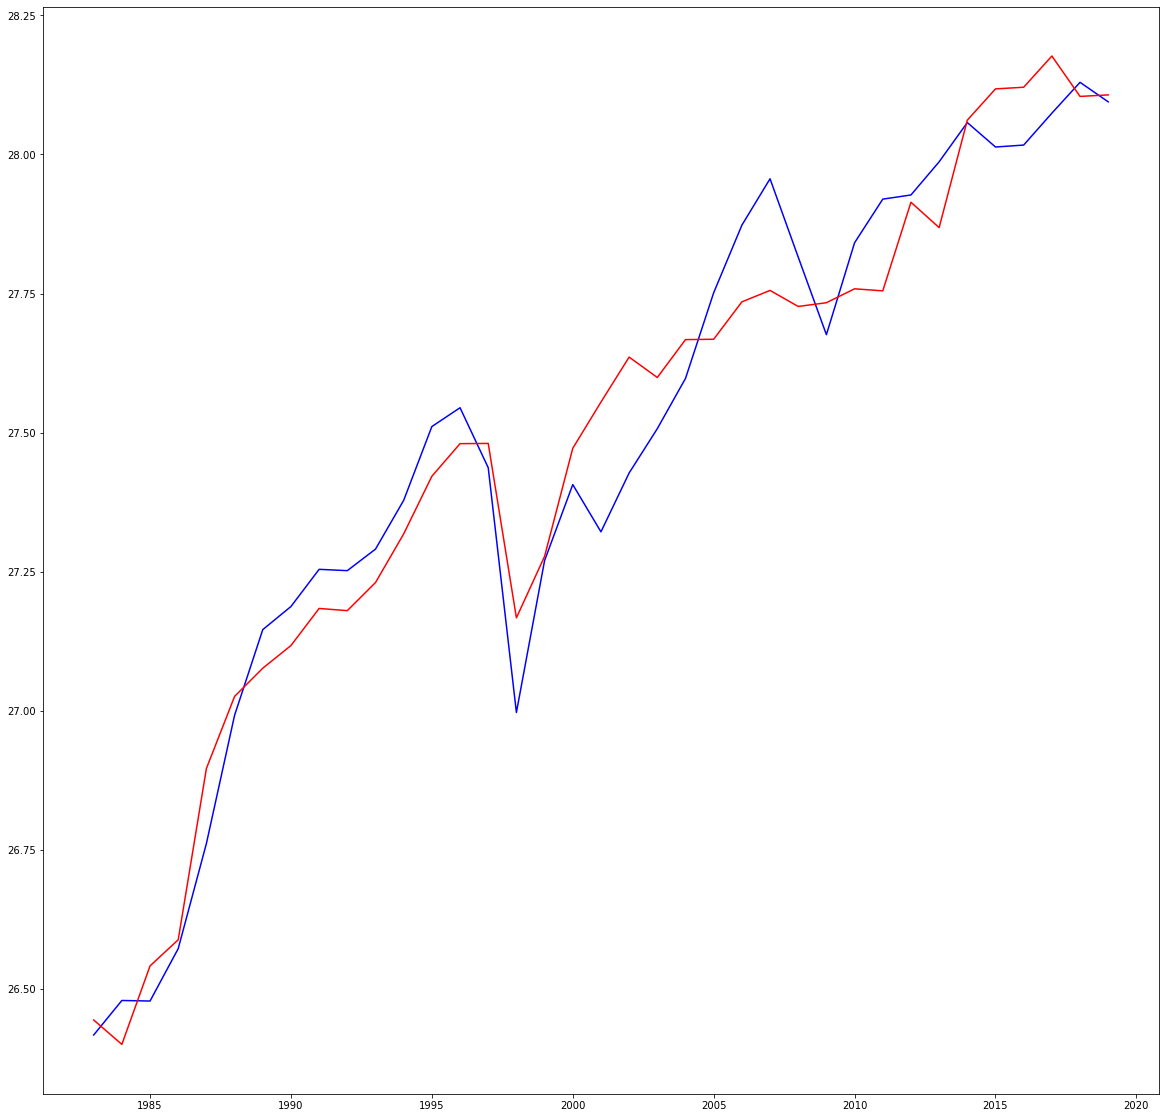

In [27]:
plt.rcParams["figure.figsize"] = (20, 20)
plt.plot(korea.index, korea['Real_gdp'], color='blue')
plt.plot(fitted.index, fitted, color='red')

c:\Users\JongHwi\anaconda3\envs\pytorch\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


c:\Users\JongHwi\anaconda3\envs\pytorch\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


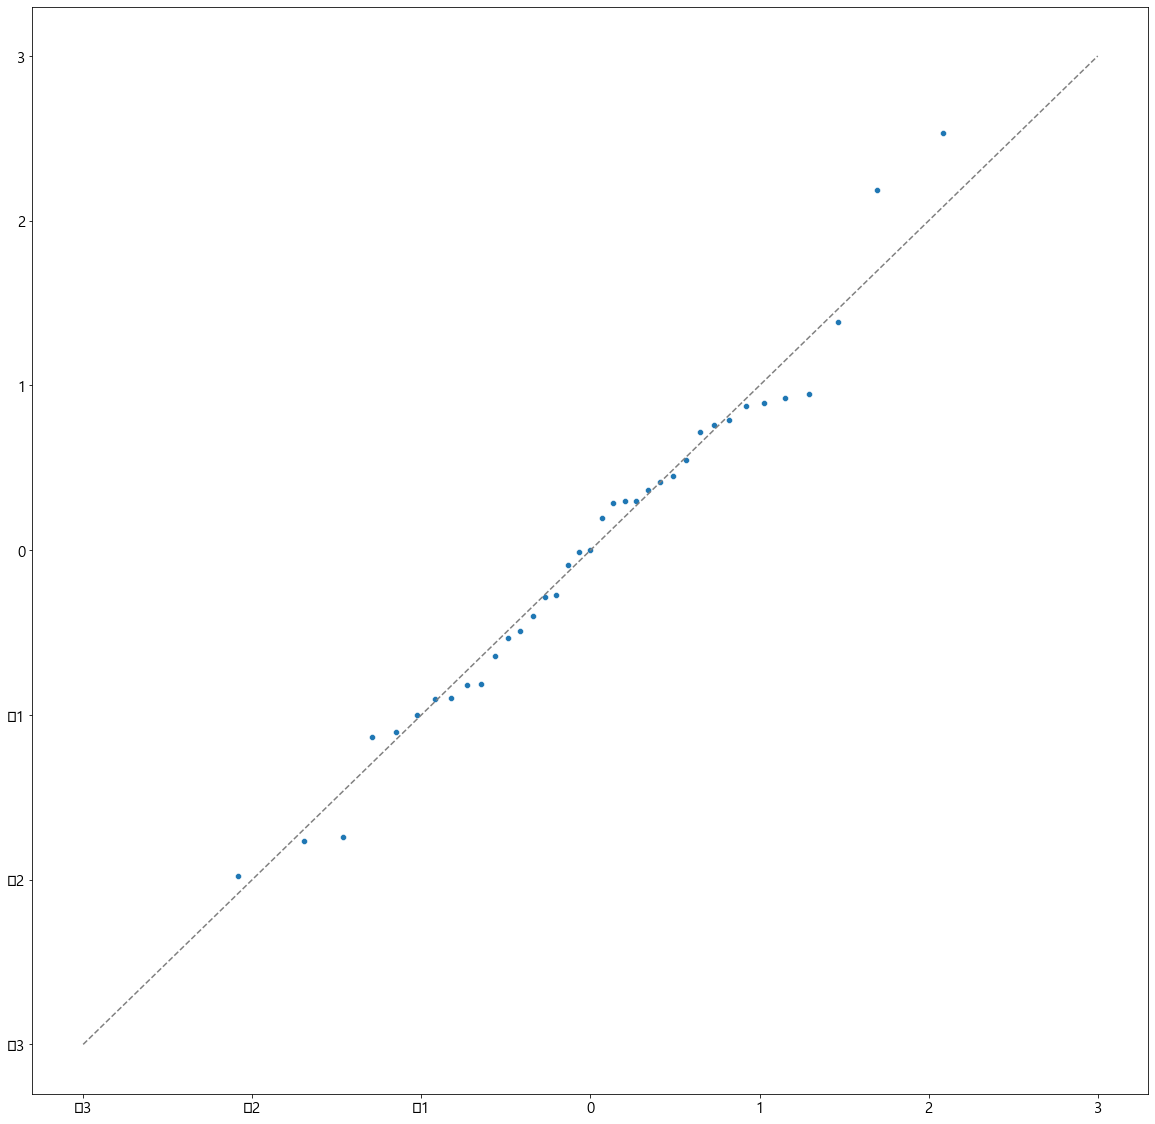

In [16]:
import scipy.stats

sr = scipy.stats.zscore(residual)
(x, y), _ = scipy.stats.probplot(sr)
sns.scatterplot(x, y)
plt.plot([-3, 3], [-3, 3], '--', color='grey')

In [46]:
japan = pd.concat([capital_stock_log['Japan'], real_gdp_log['Japan'], np.log(employment['Japan'])], axis=1)
japan.columns = ['Capital_stock', 'Real_gdp', 'Work_hours']
japan.dropna(axis=0, inplace=True)
japan['Time'] = range(1, len(japan)+1)
japan

,Capital_stock,Real_gdp,Work_hours,Time
Year,,,,
1960,14.350387,26.002524,10.700563,1
1961,14.460744,26.116241,10.713899,2
1962,14.564819,26.201583,10.726639,3
1963,14.668260,26.282920,10.735019,4
1964,14.777377,26.393358,10.748282,5
1965,14.875540,26.449925,10.764019,6
1966,14.977129,26.551023,10.784617,7
1967,15.090368,26.656124,10.803598,8
1968,15.214601,26.777300,10.820112,9


In [47]:
model = ols("Real_gdp ~ Capital_stock + Work_hours + Time", data = japan).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Real_gdp   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     1012.
Date:                Tue, 31 May 2022   Prob (F-statistic):           1.00e-48
Time:                        23:04:25   Log-Likelihood:                 31.311
No. Observations:                  60   AIC:                            -54.62
Df Residuals:                      56   BIC:                            -46.24
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -23.1188      7.529     -3.071      0.003     -38.202      -8.036
Capital_stock     0.4047      0.117      3.474      0.001       0.171       0.638
Work_hours        4.0358      0.836      4.828      0.000       2.361       5.710
Time              0.0151      0.003      5.210      0.000       0.009       0.021
==============================================================================
Omnibus:                        0.087   Durbin-Watson:                   0.468
Prob(Omnibus):                  0.957   Jarque-Bera (JB):                0.166
Skew:                           0.085   Prob(JB):                        0.920
Kurtosis:                       2.806   Cond. No.                     1.56e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.56e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [31]:
6.491e-05

6.491e-05

c:\Users\JongHwi\anaconda3\envs\pytorch\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


c:\Users\JongHwi\anaconda3\envs\pytorch\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


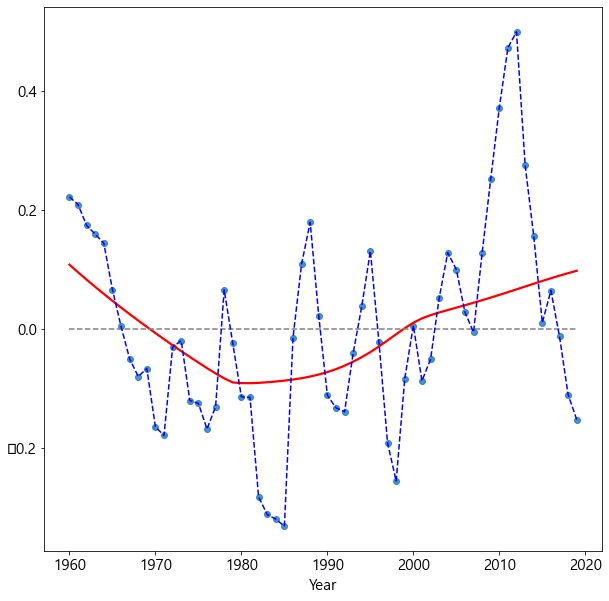

In [176]:
fitted = model.predict(japan)
residual = japan['Real_gdp'] - fitted

plt.rcParams["figure.figsize"] = (10, 10)
sns.regplot(residual.index, residual, lowess=True, line_kws={'color': 'red'})
plt.plot([residual.index.min(), residual.index.max()], [0, 0], '--', color='grey')
plt.plot(residual.index, residual, '--', color='blue')
#[출처] [파이썬 데이터 사이언스] 단순선형회귀분석(Simple Linear Regression Analysis)|작성자 친절한 박선생

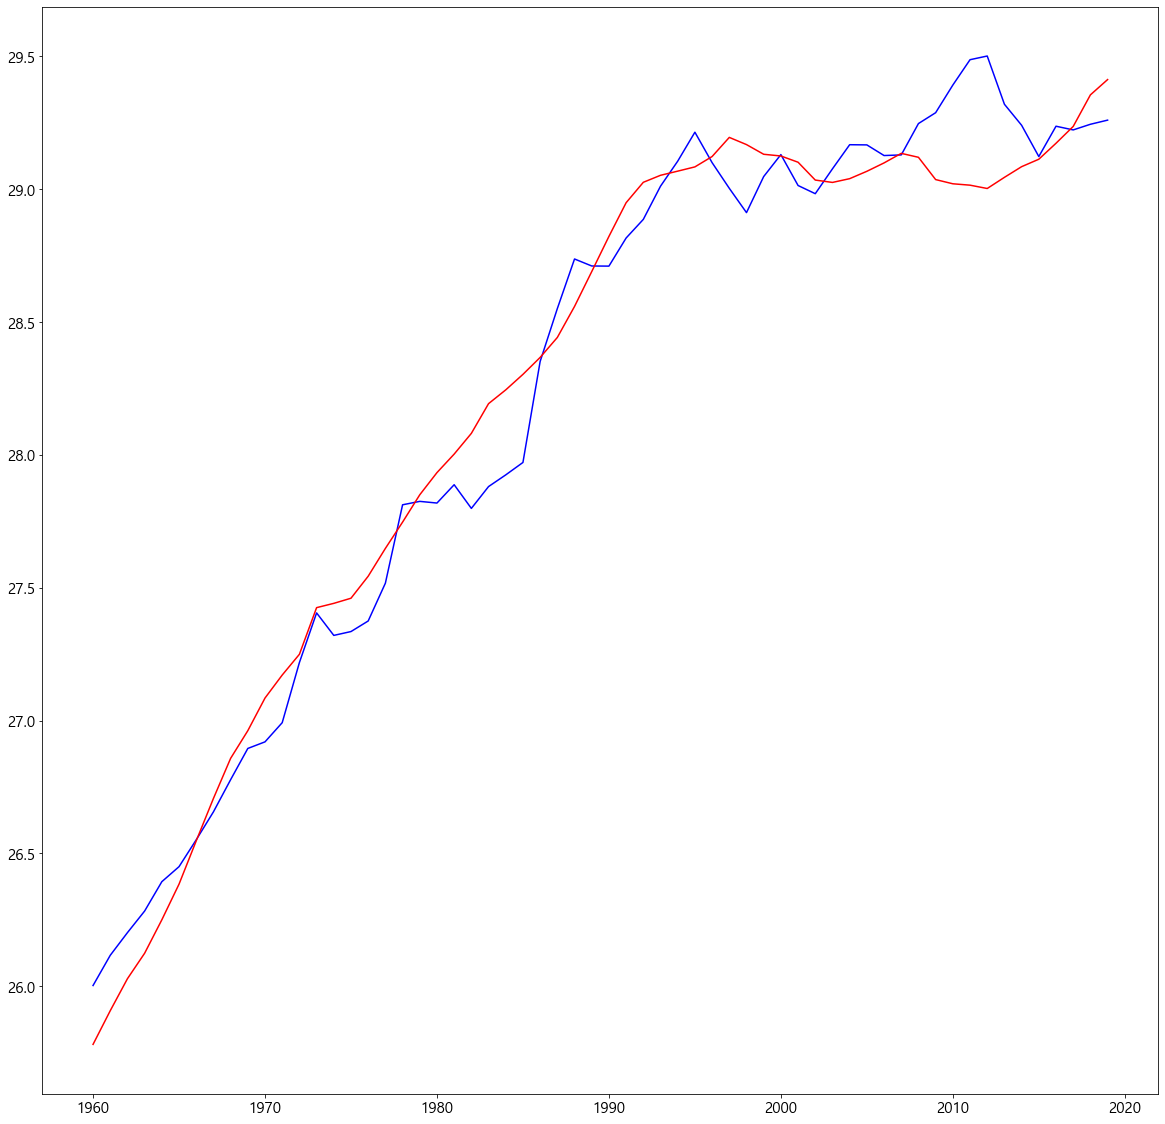

In [177]:
plt.rcParams["figure.figsize"] = (20, 20)
plt.plot(japan.index, japan['Real_gdp'], color='blue')
plt.plot(fitted.index, fitted, color='red')

c:\Users\JongHwi\anaconda3\envs\pytorch\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


c:\Users\JongHwi\anaconda3\envs\pytorch\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


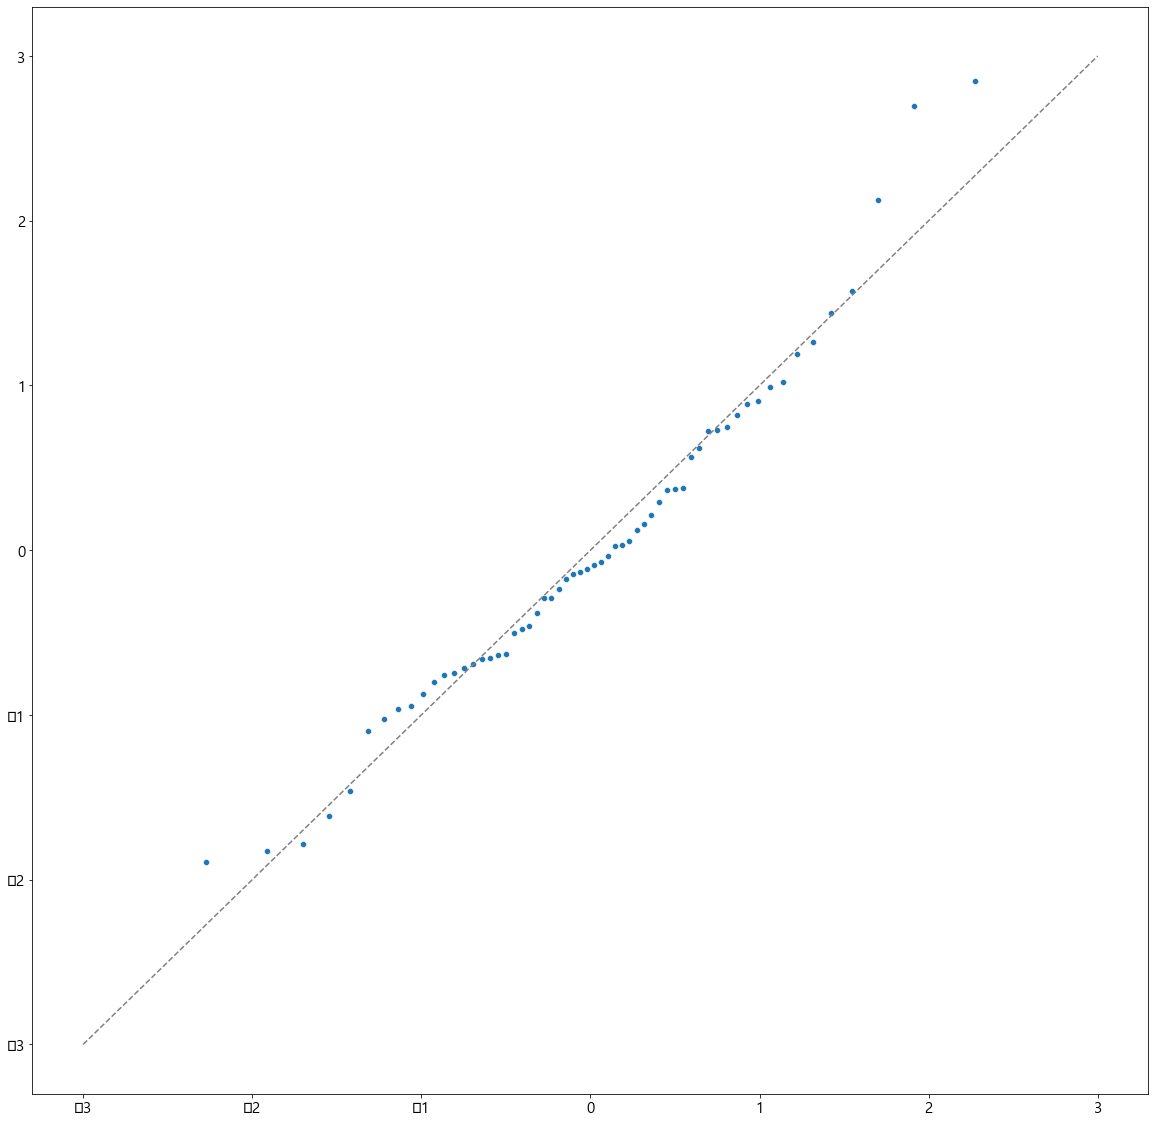

In [178]:
import scipy.stats

sr = scipy.stats.zscore(residual)
(x, y), _ = scipy.stats.probplot(sr)
sns.scatterplot(x, y)
plt.plot([-3, 3], [-3, 3], '--', color='grey')

c:\Users\JongHwi\anaconda3\envs\pytorch\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Year'>

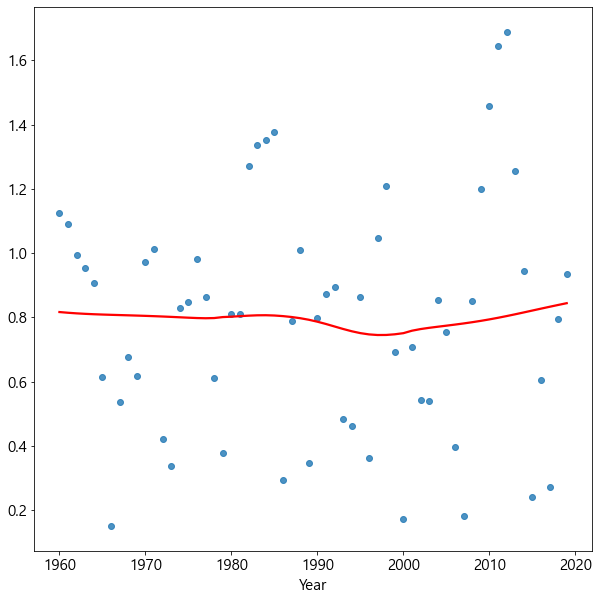

In [140]:
import numpy as np

sns.regplot(fitted.index, np.sqrt(np.abs(sr)), lowess=True, line_kws={'color': 'red'})